### All imports

In [1]:
import cv2
import matplotlib.pyplot as plt

import os
import rasterio
import numpy as np
from rasterio.plot import show
from skimage import exposure
import seaborn as sns

In [2]:
import os
import rasterio
import numpy as np

# Set the directory path containing the .tif files (X_train, y_train, X_test)
directory_paths = ['../data/raw/train_satellite', '../data/raw/train_kelp', '../data/raw/test_satellite']

# Get a list of all files in the directory (X_train, y_train, X_test)
file_list = [[file for file in os.listdir(paths) if file.endswith('.tif')] for paths in directory_paths]

# Sort the file list to ensure consistent order
file_list = [sorted(files) for files in file_list]


# Initialize an empty array to store the image data
X_train, y_train, X_test = [], [], []

# Iterate through the selected files
for X_train_name, y_train_name in zip(file_list[0], file_list[1]):
    # Construct the full path to the file
    X_train_path = os.path.join(directory_paths[0], X_train_name)
    y_train_path = os.path.join(directory_paths[1], y_train_name)

    # Open the raster file using rasterio
    with rasterio.open(X_train_path) as src:
        # Read the entire image data as a NumPy array
        image_data = src.read()

        # Append the image data to the array
        X_train.append(image_data)

    # Open the raster file using rasterio
    with rasterio.open(y_train_path) as src:
        # Read the entire image data as a NumPy array
        image_data = src.read()

        # Append the image data to the array
        y_train.append(image_data)

for X_test_name in file_list[2]:
    # Construct the full path to the file
    X_test_path = os.path.join(directory_paths[2], X_test_name)

    with rasterio.open(X_test_path) as src:
        # Read the entire image data as a NumPy array
        image_data = src.read()

        # Append the image data to the array
        X_test.append(image_data)

# Convert the list of arrays to a single NumPy array
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)

# Print the shape of the resulting array
print("Shape of the X_train array:", X_train.shape)
print("Shape of the y_train array:", y_train.shape)
print("Shape of the X_test array:", X_test.shape)

C:\Users\hjdeh\Documents\GitHub\Q2\q2-detect-kelp\venv\Lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Shape of the X_train array: (5635, 7, 350, 350)
Shape of the y_train array: (5635, 1, 350, 350)
Shape of the X_test array: (1426, 7, 350, 350)


In [14]:
# fit an sklearn standard scaler to the training data
from tqdm import tqdm
from dask_ml.preprocessing import StandardScaler
# import client from dask
from dask.distributed import Client
scaler = StandardScaler()
X_train = X_train.astype(np.float32)

In [15]:
# start a client
client = Client(memory_limit="16GB")

c:\Users\Tolga\Desktop\EPOCH-IV\q2-detect-kelp\.venv\Lib\site-packages\distributed\node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51042 instead
  warnings.warn(
C:\Users\Tolga\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:144: UserWarning: Creating scratch directories is taking a surprisingly long time. (1.78s) This is often due to running workers on a network file system. Consider specifying a local-directory to point workers to write scratch data to a local disk.
  next(self.gen)


In [16]:
for channel in tqdm(range(X_train.shape[1])):
    scaled_channel = scaler.fit_transform(X_train[:,channel,:,:].reshape(-1,1)).reshape(X_train.shape[0], X_train.shape[2], X_train.shape[3])
# scaler.fit(X_train.reshape(-1, 1))

# # apply the scaler to the training and test data
# X_train_scaled = scaler.transform(X_train.reshape(-1, 1))
# X_test_scaled = scaler.transform(X_test.reshape(-1, 1))


  0%|          | 0/7 [00:00<?, ?it/s]c:\Users\Tolga\Desktop\EPOCH-IV\q2-detect-kelp\.venv\Lib\site-packages\distributed\client.py:3162: UserWarning: Sending large graph of size 2.57 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2023-12-18 10:29:10,672 - distributed.protocol.core - CRITICAL - Failed to deserialize
Traceback (most recent call last):
  File "c:\Users\Tolga\Desktop\EPOCH-IV\q2-detect-kelp\.venv\Lib\site-packages\distributed\protocol\core.py", line 160, in loads
    return msgpack.loads(
           ^^^^^^^^^^^^^^
  File "msgpack\\_unpacker.pyx", line 194, in msgpack._cmsgpack.unpackb
ValueError: 2761150000 exceeds max_bin_len(2147483647)
2023-12-18 10:29:10,681 - distributed.core - ERROR - Exception while handling op register-client
Traceback (most recent call last):
  File "c:\Users\Tolga\Desktop\EPOCH-IV\q2-detect-kelp\.venv\Lib\site-packages\distributed\core.py", line 969, in _handle_comm
    result = await 

CancelledError: ('sqrt-5750fd2867ff123aaa310a14d45f492f', 0)

In [10]:
scaled_channel.shape

(5635, 350, 350)

In [11]:
import torch


class TorchStandardScaler:

    def __init__(self, mean=None, std=None, epsilon=1e-7):
        """Standard Scaler.
        The class can be used to normalize PyTorch Tensors using native functions. The module does not expect the
        tensors to be of any specific shape; as long as the features are the last dimension in the tensor, the module
        will work fine.
        :param mean: The mean of the features. The property will be set after a call to fit.
        :param std: The standard deviation of the features. The property will be set after a call to fit.
        :param epsilon: Used to avoid a Division-By-Zero exception.
        """
        self.mean = mean
        self.std = std
        self.epsilon = epsilon

    def fit(self, values):
        dims = [0,2,3]
        self.mean = torch.mean(values, dim=dims)
        self.std = torch.std(values, dim=dims)

    def transform(self, values):
        # apply subtract the mean and divide by std per channel
        
        return (values - self.mean) / (self.std + self.epsilon)


    def fit_transform(self, values):
        self.fit(values)
        return self.transform(values)

In [12]:
# convert the read data into PyTorch tensors and apply the scaler on torch tensors
X_train_tensor = torch.from_numpy(X_train).float()
y_train_tensor = torch.from_numpy(y_train).float()
X_test_tensor = torch.from_numpy(X_test).float()

In [13]:
scaler = TorchStandardScaler()
X_train_scaled = scaler.fit_transform(X_train_tensor)
X_test_scaled = scaler.transform(X_test_tensor)


RuntimeError: The size of tensor a (350) must match the size of tensor b (7) at non-singleton dimension 3

### Lets fit a CNN Classifier to part of X_Train and y_train with our target = in_train

In [22]:
import pandas as pd

metadata = pd.read_csv('data/metadata.csv')

train_labels = metadata[metadata['filename'].isin(file_list[0])].sort_values(by=['filename'])["in_train"].values.astype(int)
test_labels = metadata[metadata['filename'].isin(file_list[2])].sort_values(by=['filename'])["in_train"].values.astype(int)
train_labels = train_labels[:len(test_labels)]

#Concat X_train and X_test to make X_train
X = np.concatenate((X_train[:len(test_labels), 2:5,:,:], X_test[:,2:5,:,:]), axis=0)
y = np.concatenate((train_labels, test_labels), axis=0)

# Use a train test split to split the data into train and test sets
from sklearn.model_selection import train_test_split

X_in_train, X_in_test, y_in_train, y_in_test = train_test_split(X, y, stratify=y, test_size=0.2)

In [23]:
import torchvision
import torch
from torchvision.models import resnet18

model = torchvision.models.resnet18(pretrained=False, progress=True)

#Create a dataloader
from torch.utils.data import TensorDataset, DataLoader

# Create a TensorDataset
train_data = TensorDataset(torch.from_numpy(X_in_train), torch.from_numpy(y_in_train))
test_data = TensorDataset(torch.from_numpy(X_in_test), torch.from_numpy(y_in_test))

# Create a DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)


C:\Users\hjdeh\Documents\GitHub\Q2\kelp-forest-exploration\venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hjdeh\Documents\GitHub\Q2\kelp-forest-exploration\venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [29]:
# Define the loss function and optimizer
import torch.nn as nn
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

#Push to cuda

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

#Train the model
epochs = 10

for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        # Get the inputs
        inputs, labels = data
        labels = labels.type(torch.LongTensor)
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward + backward + optimize
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Print statistics
        running_loss += loss.item()
        print(f"Epoch: {epoch + 1}, Batch: {i + 1}, Avg. Loss: {running_loss / 100}")
        running_loss = 0.0
            
 




Epoch: 1, Batch: 1, Avg. Loss: 0.0066308677196502686
Epoch: 1, Batch: 2, Avg. Loss: 0.006776771545410156
Epoch: 1, Batch: 3, Avg. Loss: 0.00866899013519287
Epoch: 1, Batch: 4, Avg. Loss: 0.0073650145530700685
Epoch: 1, Batch: 5, Avg. Loss: 0.006886247396469116
Epoch: 1, Batch: 6, Avg. Loss: 0.006465904712677002
Epoch: 1, Batch: 7, Avg. Loss: 0.007532583475112915
Epoch: 1, Batch: 8, Avg. Loss: 0.008646913766860963
Epoch: 1, Batch: 9, Avg. Loss: 0.008923524618148803
Epoch: 1, Batch: 10, Avg. Loss: 0.00974959135055542
Epoch: 1, Batch: 11, Avg. Loss: 0.0082379549741745
Epoch: 1, Batch: 12, Avg. Loss: 0.007091467976570129
Epoch: 1, Batch: 13, Avg. Loss: 0.007101547122001648
Epoch: 1, Batch: 14, Avg. Loss: 0.00713743269443512
Epoch: 1, Batch: 15, Avg. Loss: 0.006499334573745728
Epoch: 1, Batch: 16, Avg. Loss: 0.00840948462486267
Epoch: 1, Batch: 17, Avg. Loss: 0.007234880924224854
Epoch: 1, Batch: 18, Avg. Loss: 0.007369353175163269
Epoch: 1, Batch: 19, Avg. Loss: 0.006950411200523377
Epoch:

In [30]:
# Calculate the validation accuracy
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        # Get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(inputs.float())
        
        # Get predictions from the maximum value
        _, predicted = torch.max(outputs.data, 1)
        
        # Count total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

In [28]:
print(correct / total)

0.500875656742557


Te Lets look at the distribution of the data for each band for train and test. (First 1000 images)

In [89]:
bands = ["SWIR", "NIR", "Red", "Green", "Blue", "Cloud Mask", "Digital Elevation Map"]

# Calculate the min, max, average, and standard deviation values across each channel over all images
print("Train")
min_values = np.min(X_train[:1000], axis=(0, 2, 3))
max_values = np.max(X_train[:1000], axis=(0, 2, 3))
avg_values = np.mean(X_train[:1000], axis=(0, 2, 3))
std_values = np.std(X_train[:1000], axis=(0, 2, 3))

# Print or use the results as needed
for band, (min_val, max_val, avg_val, std_val) in enumerate(zip(min_values, max_values, avg_values, std_values)):
    print(f"Band {bands[band]:<25}: Min = {min_val:<6}, Max = {max_val:<5}, Avg = {avg_val:<8.2f}, Std = {std_val:.2f}")
    
print("\nTest")
min_values = np.min(X_test[:1000], axis=(0, 2, 3))
max_values = np.max(X_test[:1000], axis=(0, 2, 3))
avg_values = np.mean(X_test[:1000], axis=(0, 2, 3))
std_values = np.std(X_test[:1000], axis=(0, 2, 3))

# Print or use the results as needed
for band, (min_val, max_val, avg_val, std_val) in enumerate(zip(min_values, max_values, avg_values, std_values)):
    print(f"Band {bands[band]:<25}: Min = {min_val:<6}, Max = {max_val:<5}, Avg = {avg_val:<8.2f}, Std = {std_val:.2f}")

Train
Band SWIR                     : Min = -32768, Max = 65535, Avg = 8305.59 , Std = 8974.98
Band NIR                      : Min = -32768, Max = 65535, Avg = 8981.43 , Std = 9467.97
Band Red                      : Min = -32768, Max = 65535, Avg = 7123.30 , Std = 8328.68
Band Green                    : Min = -32768, Max = 65535, Avg = 7242.59 , Std = 8331.64
Band Blue                     : Min = -32768, Max = 65535, Avg = 6913.43 , Std = 8285.66
Band Cloud Mask               : Min = 0     , Max = 1    , Avg = 0.07    , Std = 0.25
Band Digital Elevation Map    : Min = -32768, Max = 646  , Avg = -987.34 , Std = 5640.26

Test
Band SWIR                     : Min = -32768, Max = 65535, Avg = 8467.60 , Std = 8957.00
Band NIR                      : Min = -32768, Max = 65535, Avg = 9131.97 , Std = 9424.25
Band Red                      : Min = -32768, Max = 65535, Avg = 7165.55 , Std = 8233.15
Band Green                    : Min = -32768, Max = 65535, Avg = 7280.21 , Std = 8237.08
Band Blue   

In [125]:
X_train_small = X_train[10:20].copy()
X_test_small = X_test[10:20].copy()

#Remove NaNs
X_train_small[X_train_small == -32768] = 0
X_test_small[X_test_small == -32768] = 0


#Normalize bands 1-5 to between 0 and 1
X_train_small = X_train_small / 65535.0
X_test_small  = X_test_small / 65535.0

### Visualization 1: Distribution of pixel values for each band for train and test

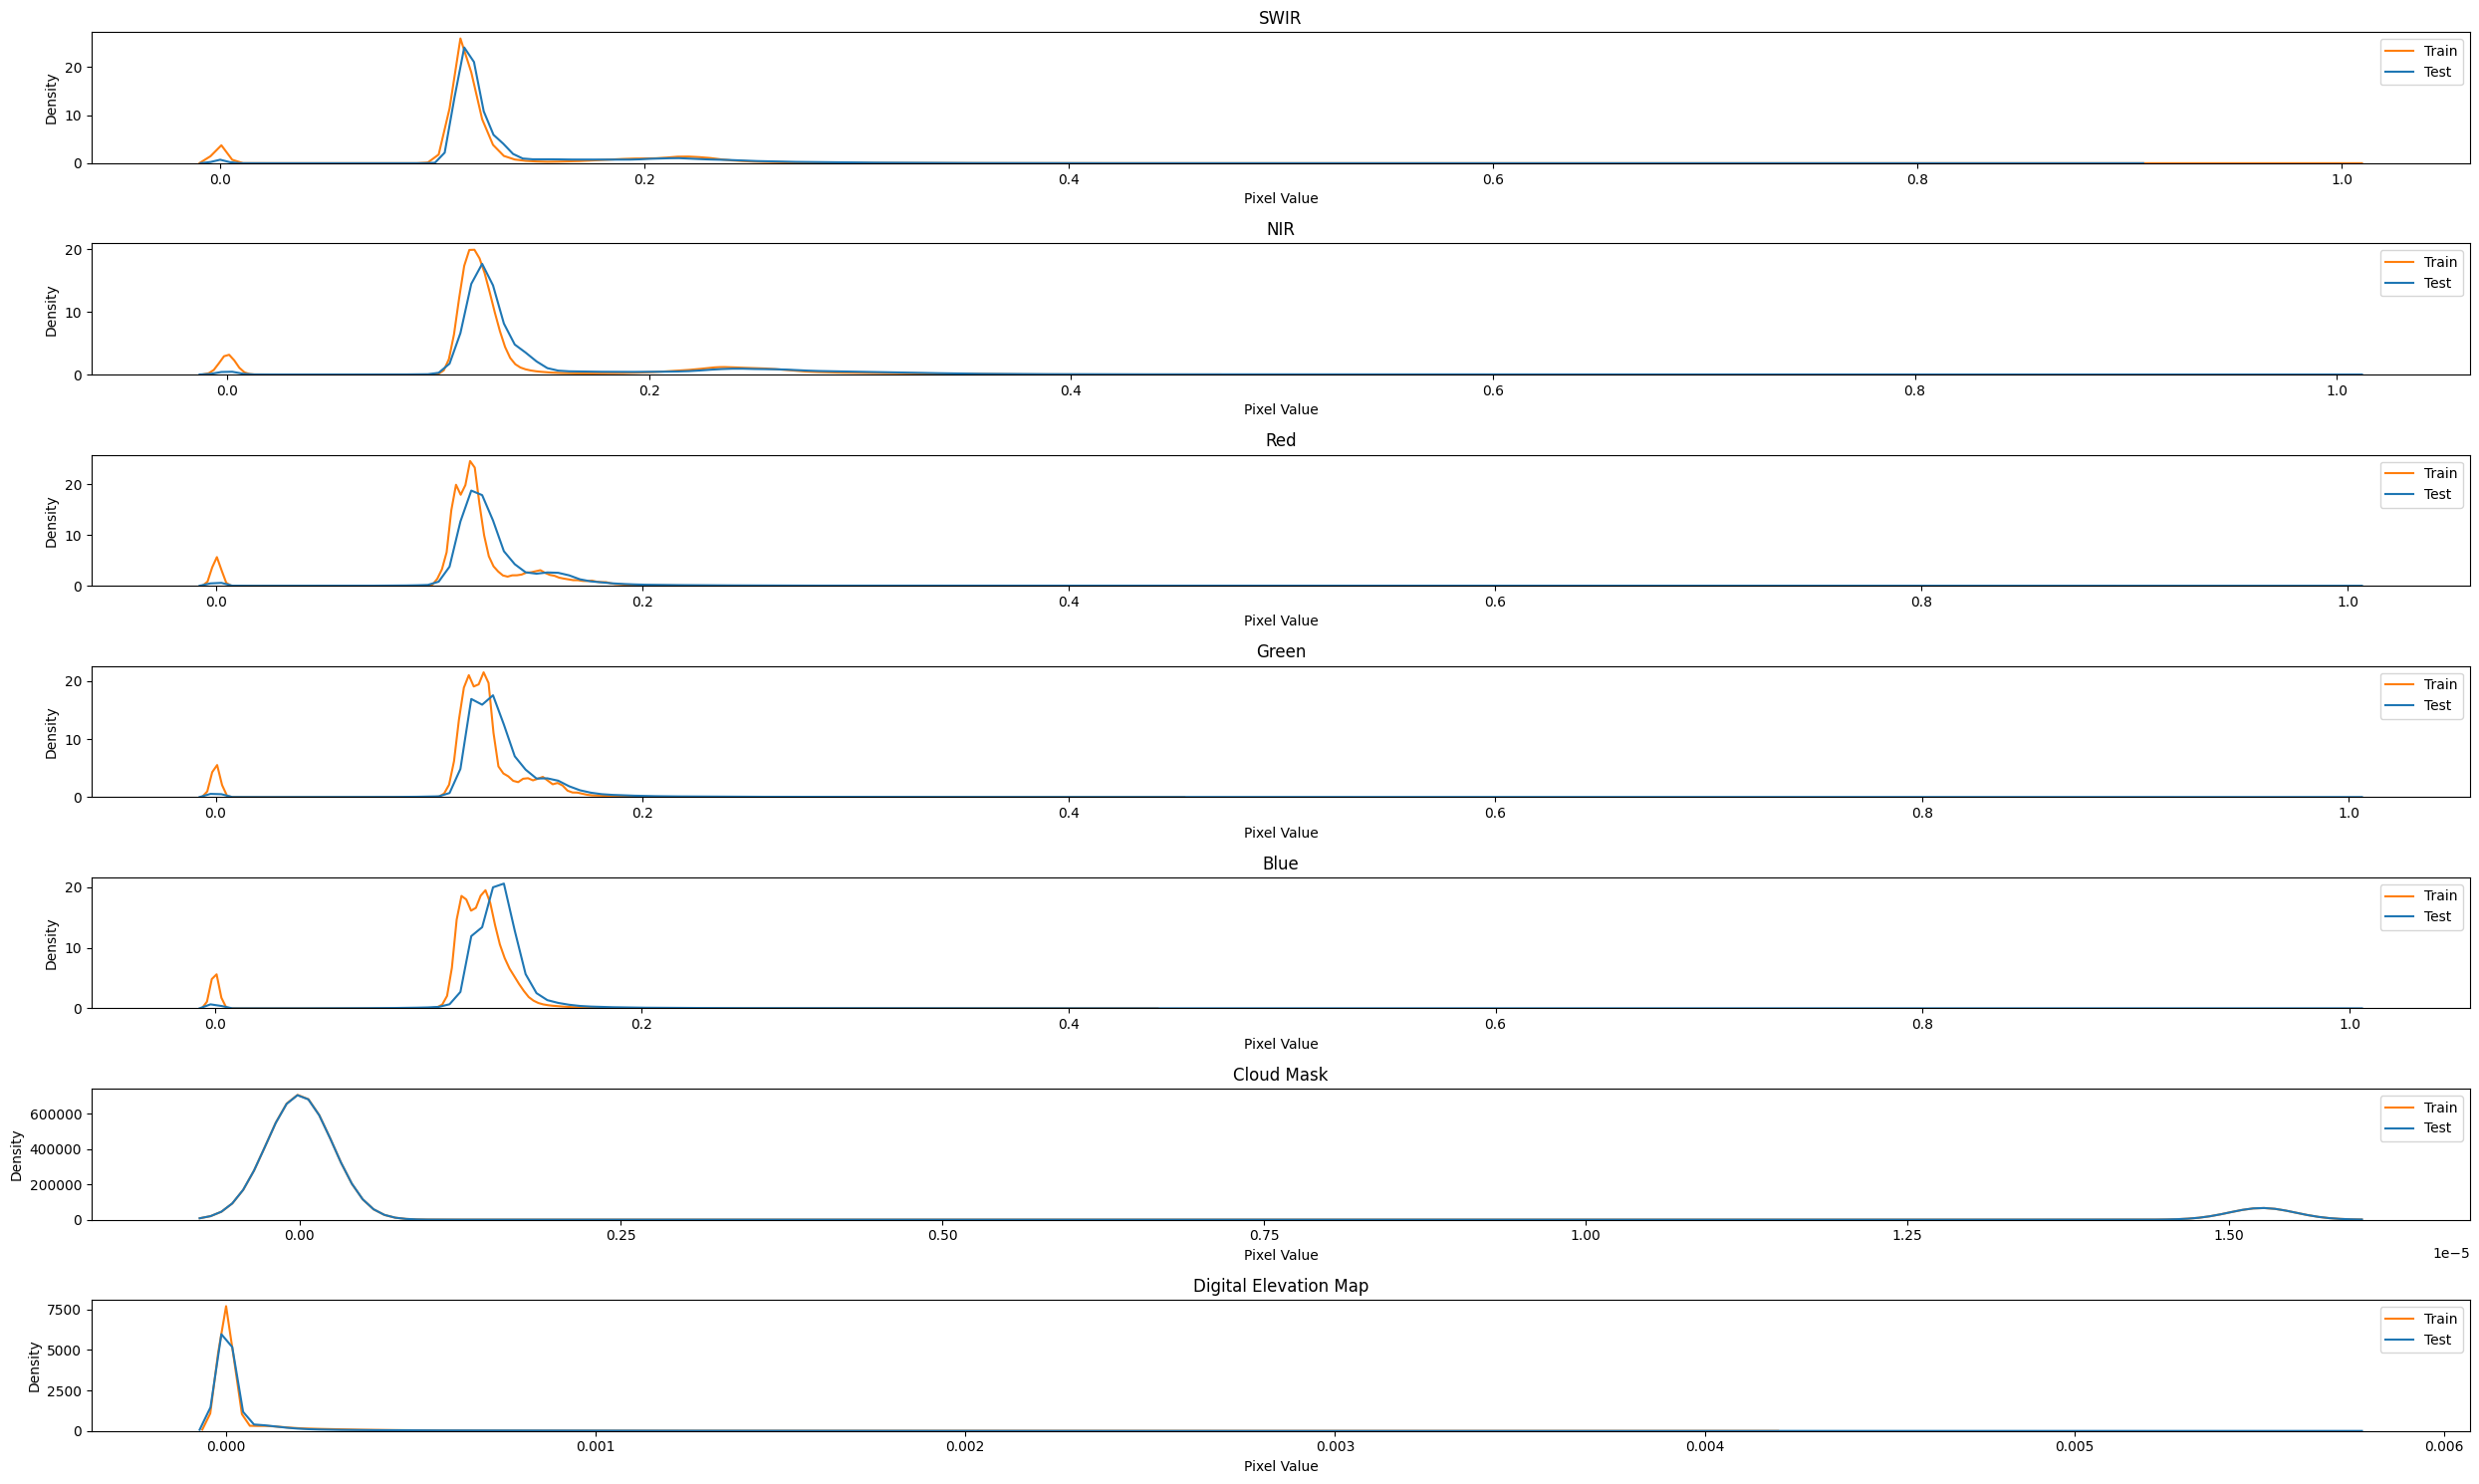

In [131]:
# Create boxplots for each band for train and test
fig, axes = plt.subplots(7,1, figsize=(25, 15))

#Plot using seaborn:
for band in range(7):
    sns.kdeplot(data=[X_train_small[:, band, :, :][:10].flatten(), X_test_small[:, band, :, :][:10].flatten()], ax=axes[band])
    axes[band].set_title(bands[band])
    axes[band].set_xlabel("Pixel Value")
    axes[band].set_ylabel("Density")
    axes[band].legend(["Train", "Test"])
    
plt.tight_layout()


We see that there are some -32768 values which are NaNs. lets calculate the NaN percentage for each band for train and test.

In [132]:
# Count the number of -32768 values for each band. These are NaNs, calculate the percentage of NaNs for each band
print("Train")
nan_count = np.sum(X_train[:1000] == -32768, axis=(0, 2, 3))

nan_percentage = nan_count / (X_train[:1000].shape[0] * X_train[:1000].shape[2] * X_train[:1000].shape[3]) * 100

for band, nan_count, nan_percent in zip(bands, nan_count, nan_percentage):
    print(f"Band {band:<25}: NaN Count = {nan_count:<6}, NaN Percentage = {nan_percent:.2f}%")
    
print("\nTest")
nan_count = np.sum(X_test[:1000] == -32768, axis=(0, 2, 3))

nan_percentage = nan_count / (X_test[:1000].shape[0] * X_test[:1000].shape[2] * X_test[:1000].shape[3]) * 100

for band, nan_count, nan_percent in zip(bands, nan_count, nan_percentage):
    print(f"Band {band:<25}: NaN Count = {nan_count:<6}, NaN Percentage = {nan_percent:.2f}%")

Train
Band SWIR                     : NaN Count = 4757603, NaN Percentage = 3.88%
Band NIR                      : NaN Count = 4758780, NaN Percentage = 3.88%
Band Red                      : NaN Count = 4767002, NaN Percentage = 3.89%
Band Green                    : NaN Count = 4767638, NaN Percentage = 3.89%
Band Blue                     : NaN Count = 4843894, NaN Percentage = 3.95%
Band Cloud Mask               : NaN Count = 0     , NaN Percentage = 0.00%
Band Digital Elevation Map    : NaN Count = 3617941, NaN Percentage = 2.95%

Test
Band SWIR                     : NaN Count = 4650240, NaN Percentage = 3.80%
Band NIR                      : NaN Count = 4650951, NaN Percentage = 3.80%
Band Red                      : NaN Count = 4656109, NaN Percentage = 3.80%
Band Green                    : NaN Count = 4654526, NaN Percentage = 3.80%
Band Blue                     : NaN Count = 4696436, NaN Percentage = 3.83%
Band Cloud Mask               : NaN Count = 0     , NaN Percentage = 0.00%
Ba

### Visualization 2: Distribution of labels
Now lets look at how balanced the labels are. 0 = no kelp, 1 = kelp

Label Counts: {0: 685615166, 1: 4672334}
Label Percentages: {0: 99.32313217318871, 1: 0.6768678268112923}


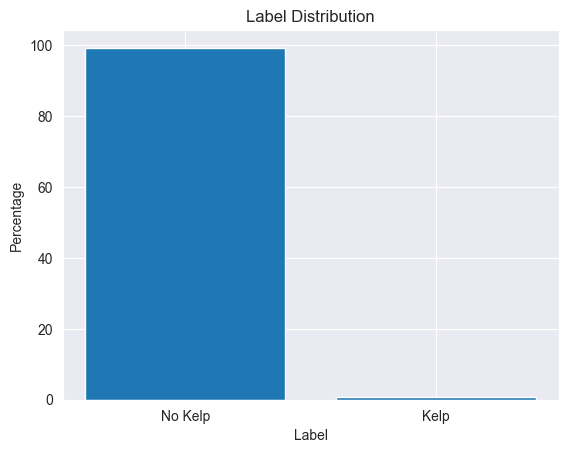

In [5]:
import matplotlib.pyplot as plt
# Count the number of 0s and 1s in the labels
unique, counts = np.unique(y_train.ravel(), return_counts=True)

# Print the results
print("Label Counts:", dict(zip(unique, counts)))

#Print the percentage of 0s and 1s
print("Label Percentages:", dict(zip(unique, counts / np.sum(counts) * 100)))

# Plot the results as a bar chart to visualize the distribution with percentages
plt.bar(unique, counts / np.sum(counts) * 100)
plt.xticks(unique)
plt.xlabel("Label")
plt.ylabel("Percentage")
plt.title("Label Distribution")

#Rename the labels to "No Kelp" and "Kelp"
plt.xticks(unique, ["No Kelp", "Kelp"])
plt.show()

In [15]:
test = y_train.ravel()
print(test[test == 1].shape)
print(test[test == 0].shape)

print(test[test == 1].shape[0] / (test[test == 0].shape[0] + test[test == 1].shape[0]))
print(test[test == 0].shape[0] / (test[test == 0].shape[0] + test[test == 1].shape[0]))

(4672334,)
(685615166,)
0.0067686782681129236
0.9932313217318871


In [8]:
print(350*350*len(y_train))

690287500


### Visualization 3: Visualize some labelled images

In [173]:
X_train_small = X_train[10:20].copy()
y_train_small = y_train[10:20].copy()

#Remove NaNs
X_train_small[X_train_small == -32768] = 0
X_test_small[X_test_small == -32768] = 0

Scale between 0 and 255 (8 bit unsigned) for visualizations

In [174]:
# Scale the data from unsigned 16-bit to 8-bit range (0-255)
scaled_images_array = exposure.rescale_intensity(X_train_small, in_range=(0, 65535), out_range=(0, 255))
normalized_images_array = X_train_small / 65535.0

Let's take a look at some satellite images. The first image = RGB, second = (SWIR, NIR, Red), third = (SWIR, NIR, Red) + label

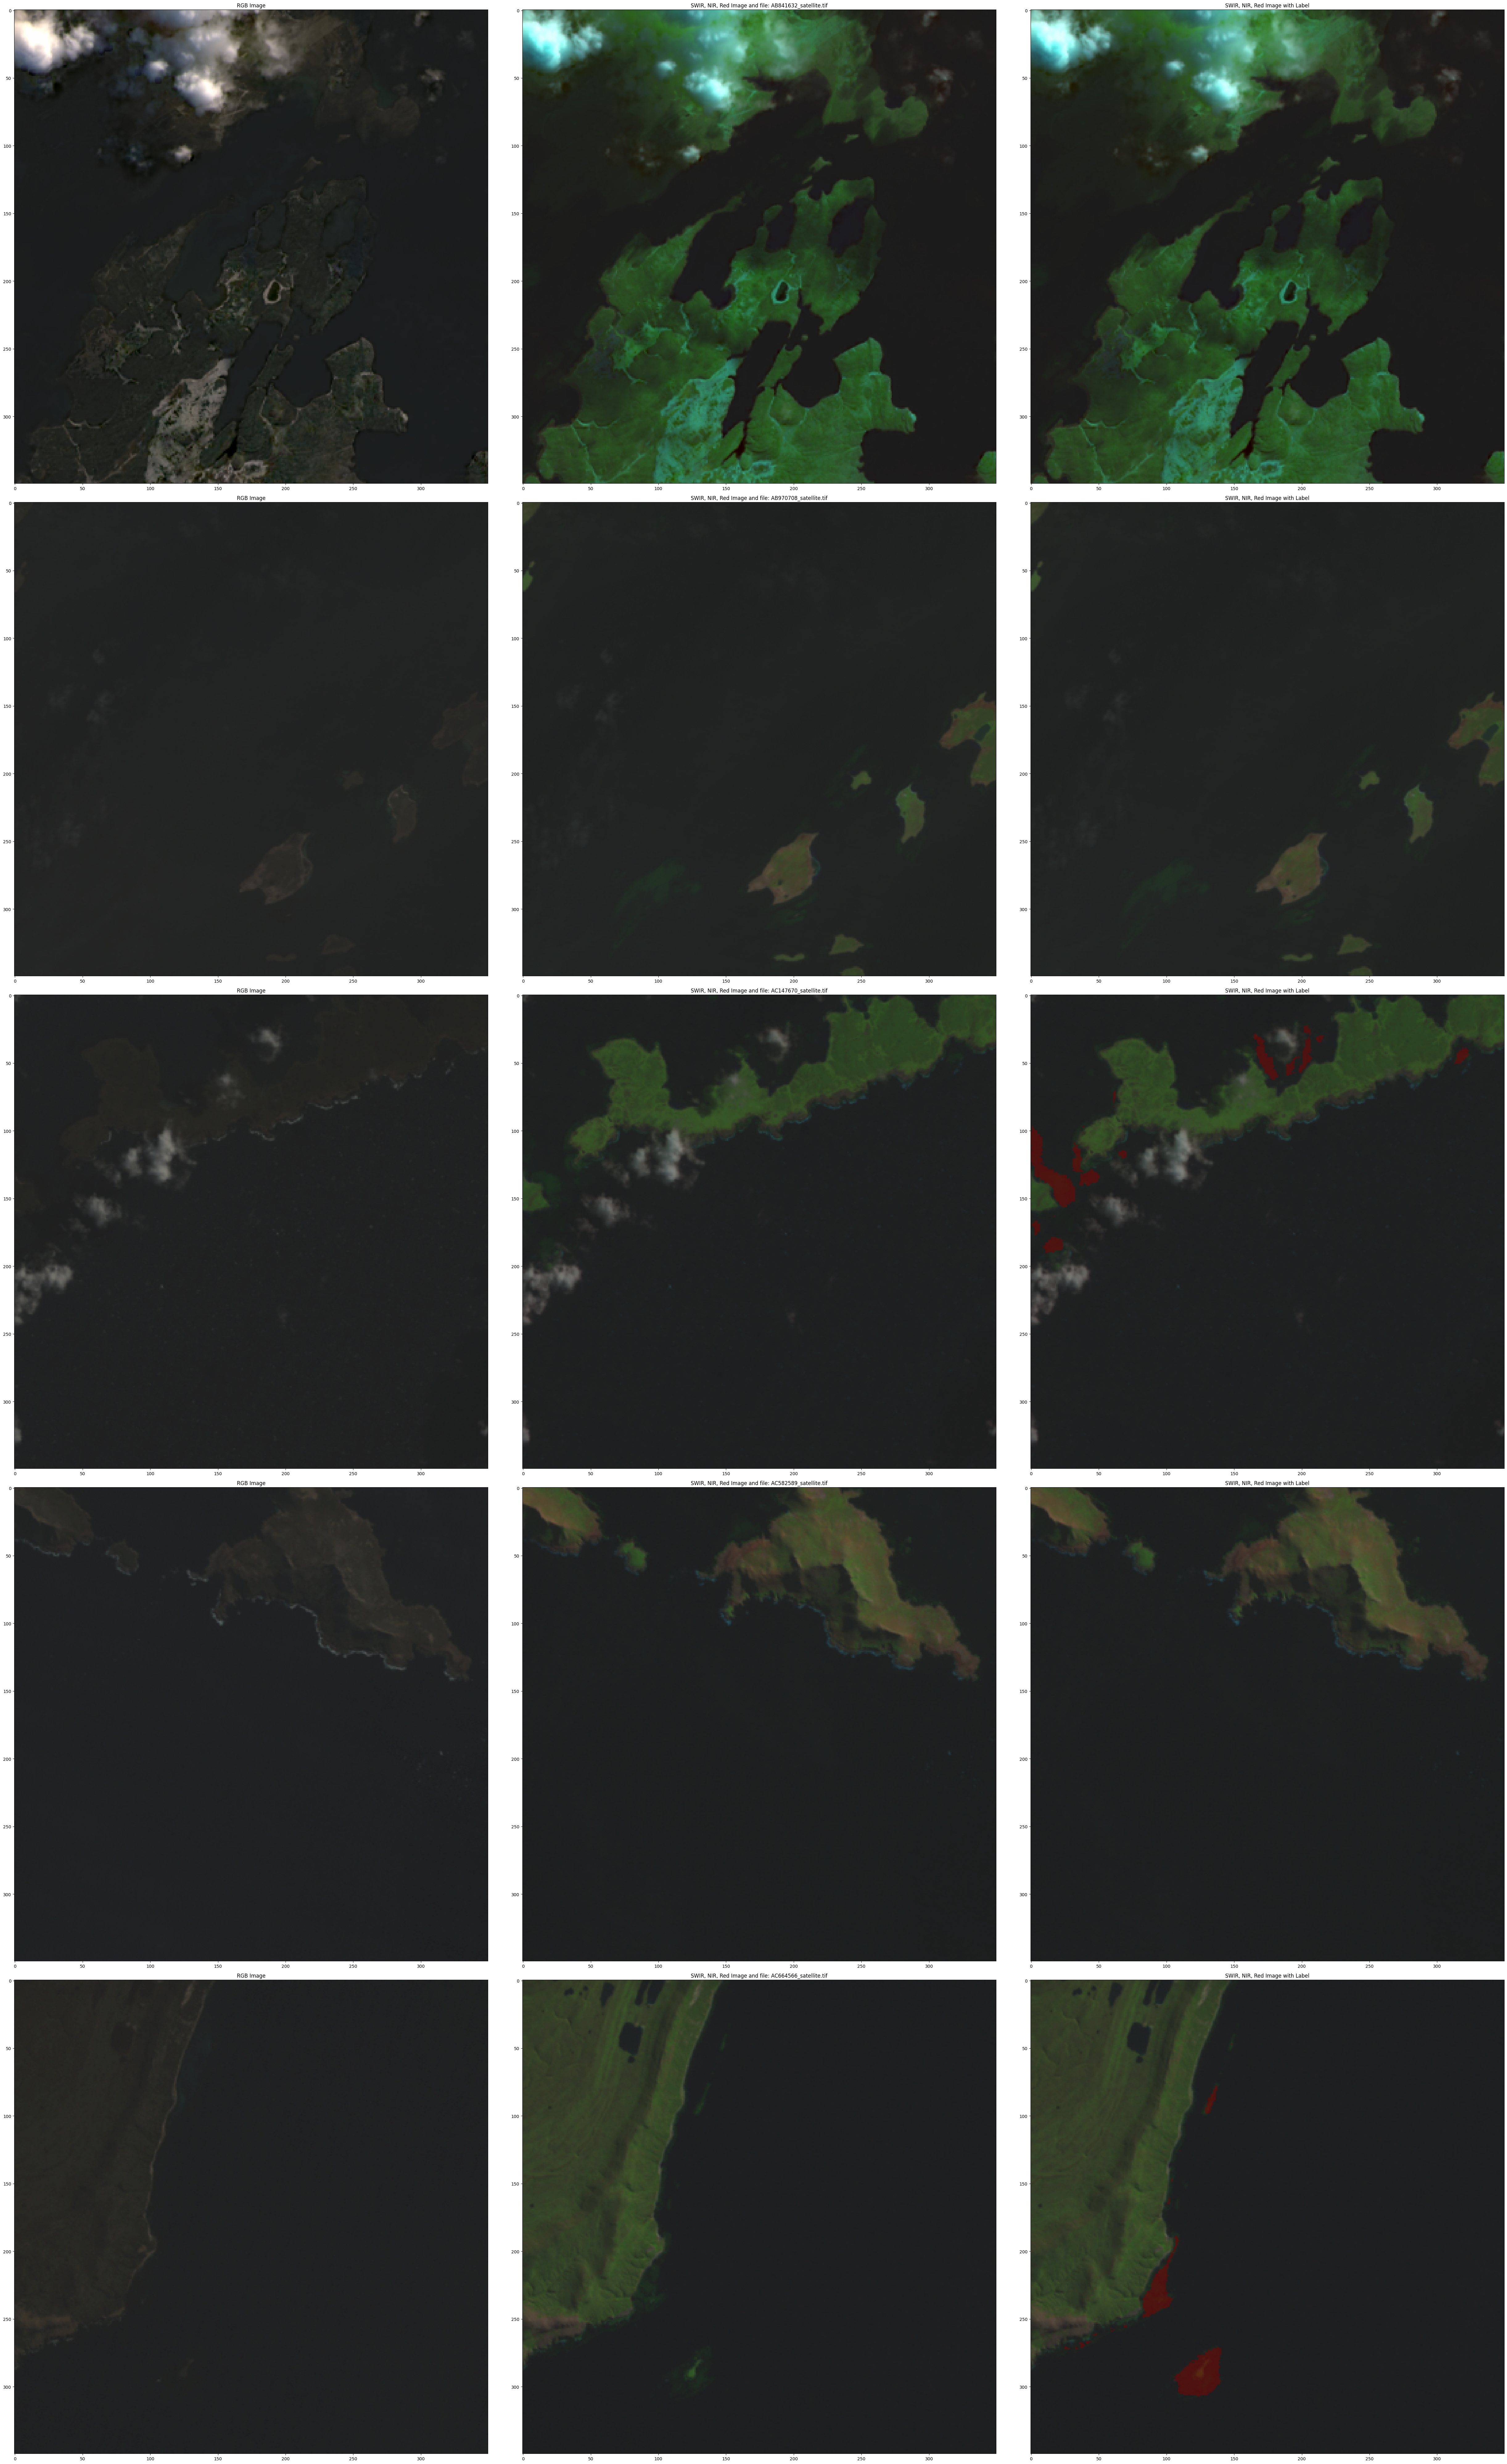

<Figure size 640x480 with 0 Axes>

In [178]:
from matplotlib.colors import ListedColormap

# Create a 2x3 grid for image display
num_rows = 5
num_cols = 3


# Create a figure and subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(50, 80))

# Flatten the 2D array of subplots into a 1D array
axes = axes.flatten()
c = 0
cmap_mask = ListedColormap(['white', 'none'])
# Display each image in a subplot
for i in range(0, num_rows * num_cols, 3):
    # Display the RGB image
    show(normalized_images_array[c, 2:5, : , :], ax=axes[i])
    axes[i].set_title("RGB Image")
    
    # Display the SWIR, NIR, Red image
    show(normalized_images_array[c, 0:3, : , :], ax=axes[i + 1])
    
    
    axes[i + 1].set_title(f"SWIR, NIR, Red Image and file: {file_list[0][c+10]}")
    
    # Display the SWIR, NIR, Red image with the label
    show(normalized_images_array[c, 0:3, : , :], ax=axes[i + 2])
    axes[i + 2].imshow(y_train_small[c][0], cmap='jet', alpha=0.5*(y_train_small[c][0]>0))
    axes[i + 2].set_title("SWIR, NIR, Red Image with Label")
    
    c += 1

# Adjust layout for better spacing
plt.tight_layout()
plt.show()
plt.savefig('images/visualize_images.png')

<Axes: >

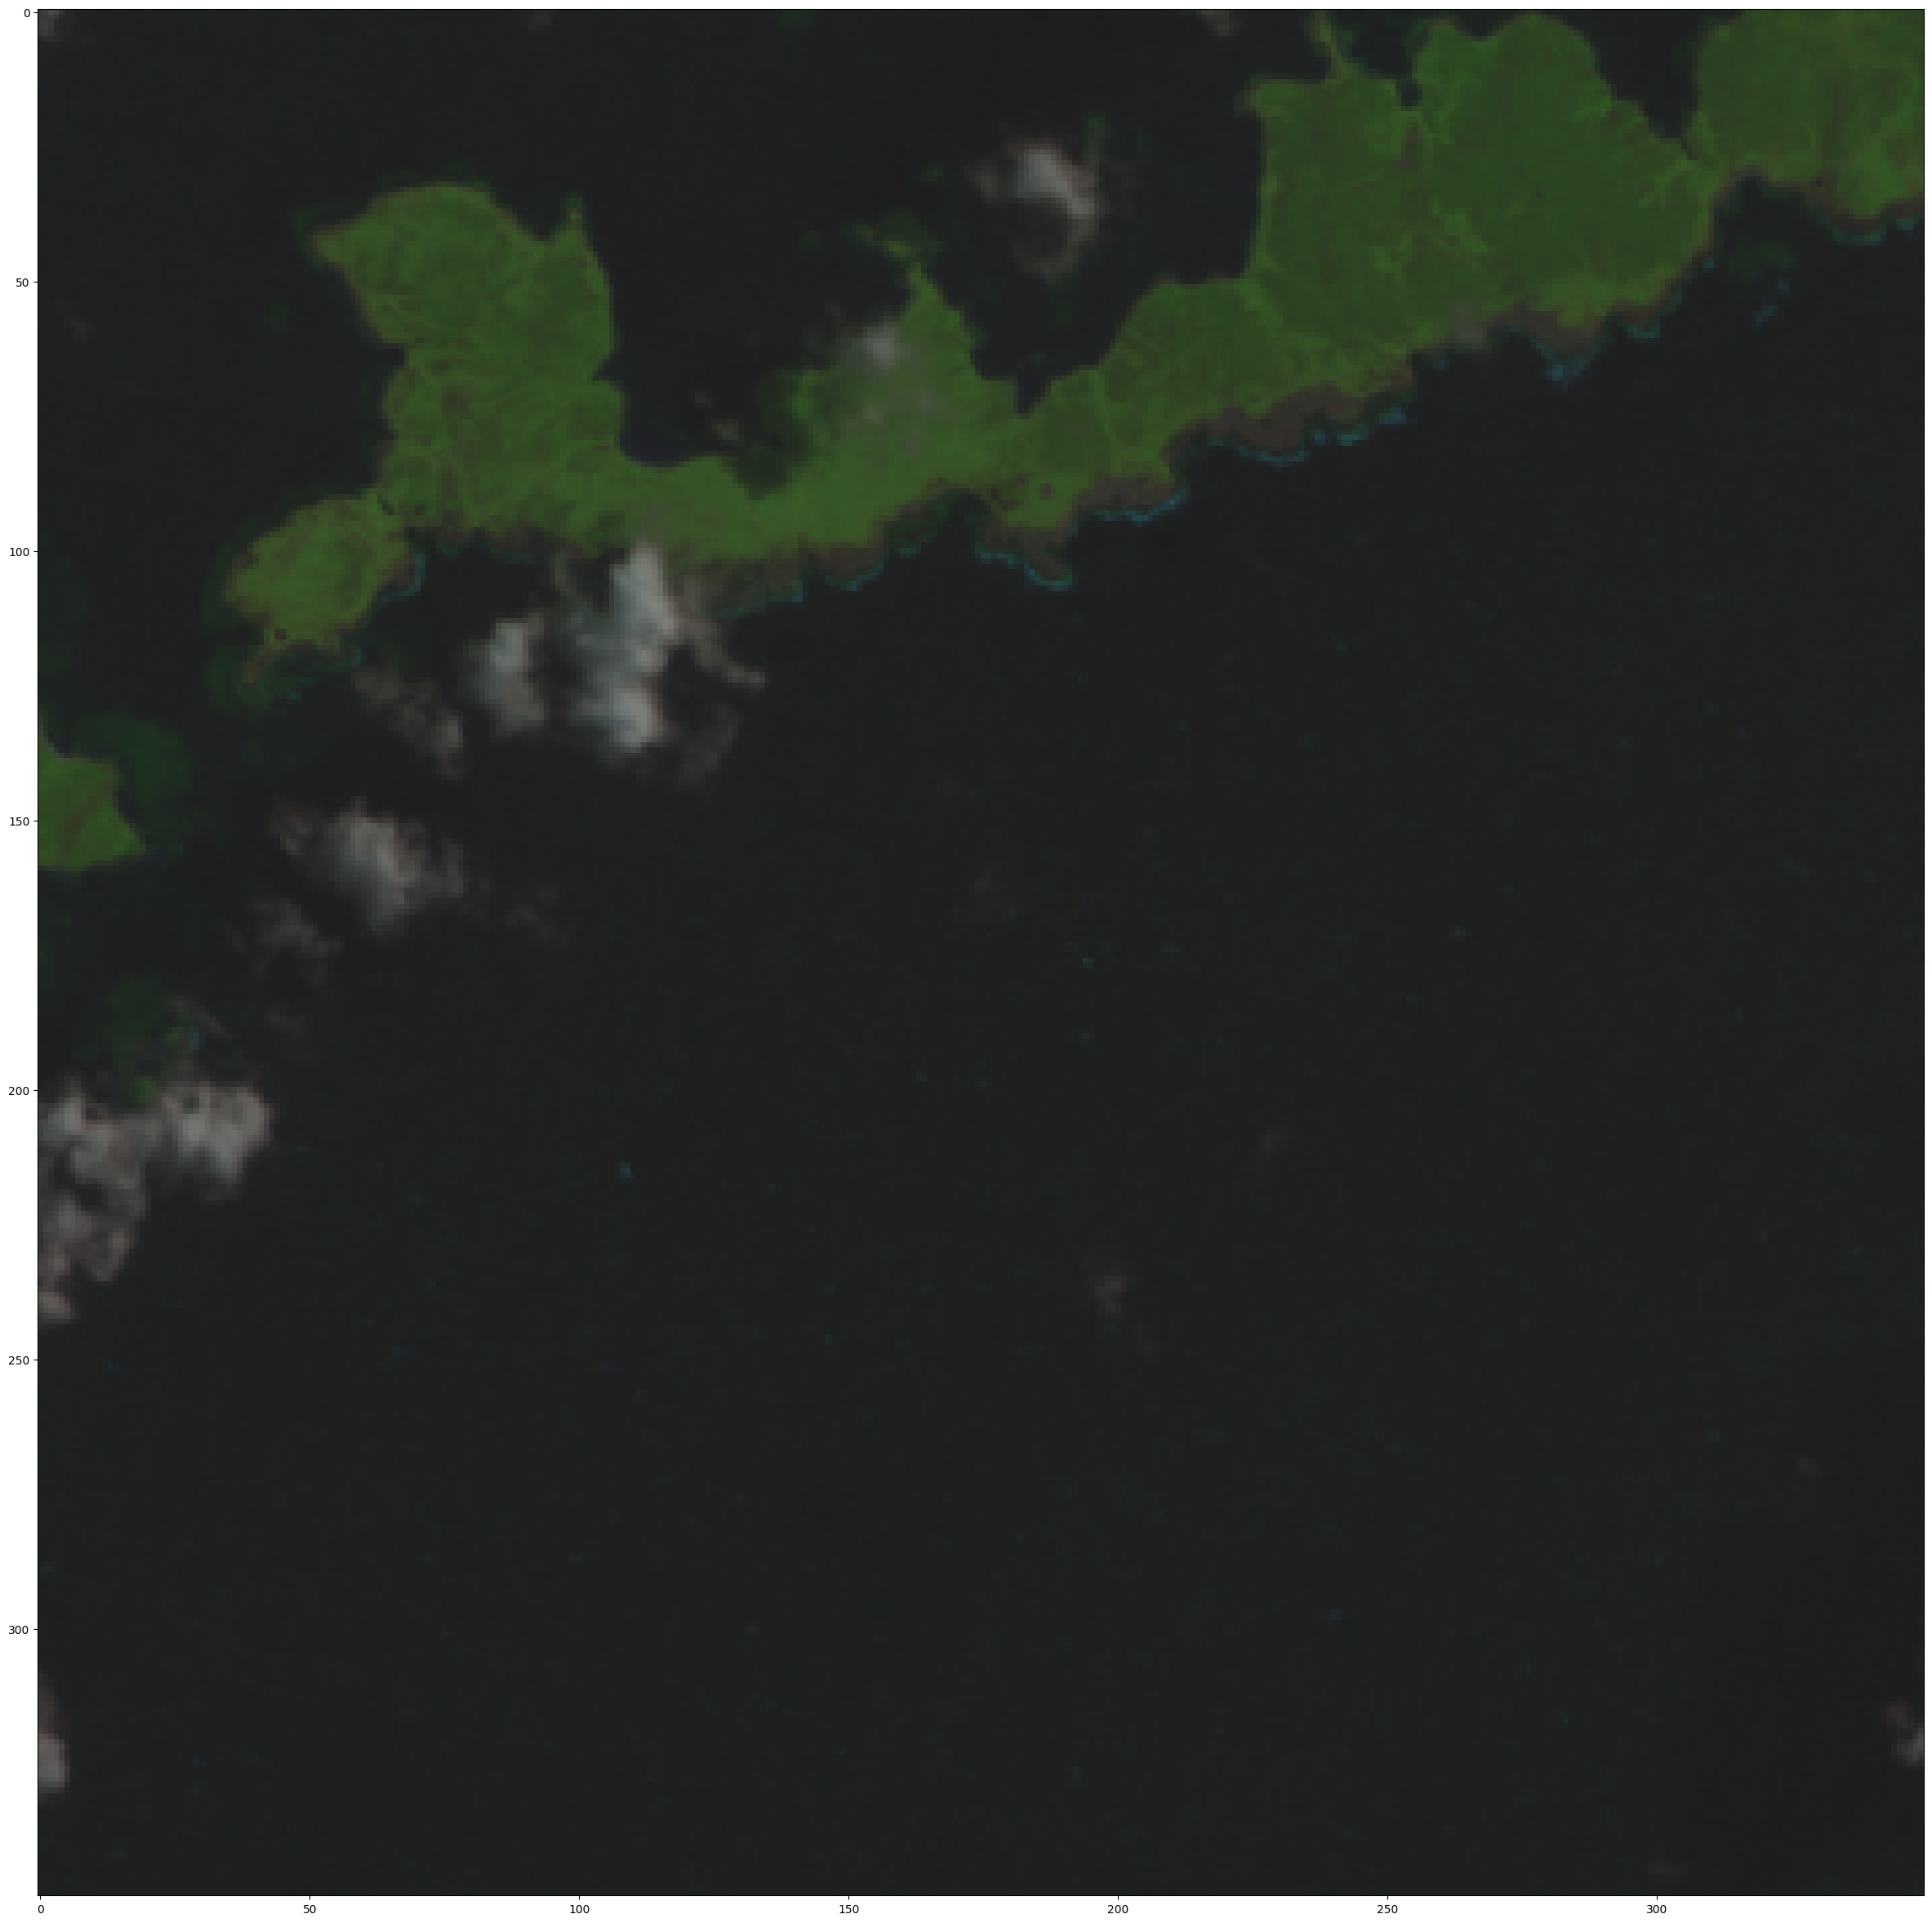

In [186]:
fig, axes = plt.subplots(1,1 , figsize=(30,30))

c = 2
show(normalized_images_array[2, 0:3, : , :], ax = axes)

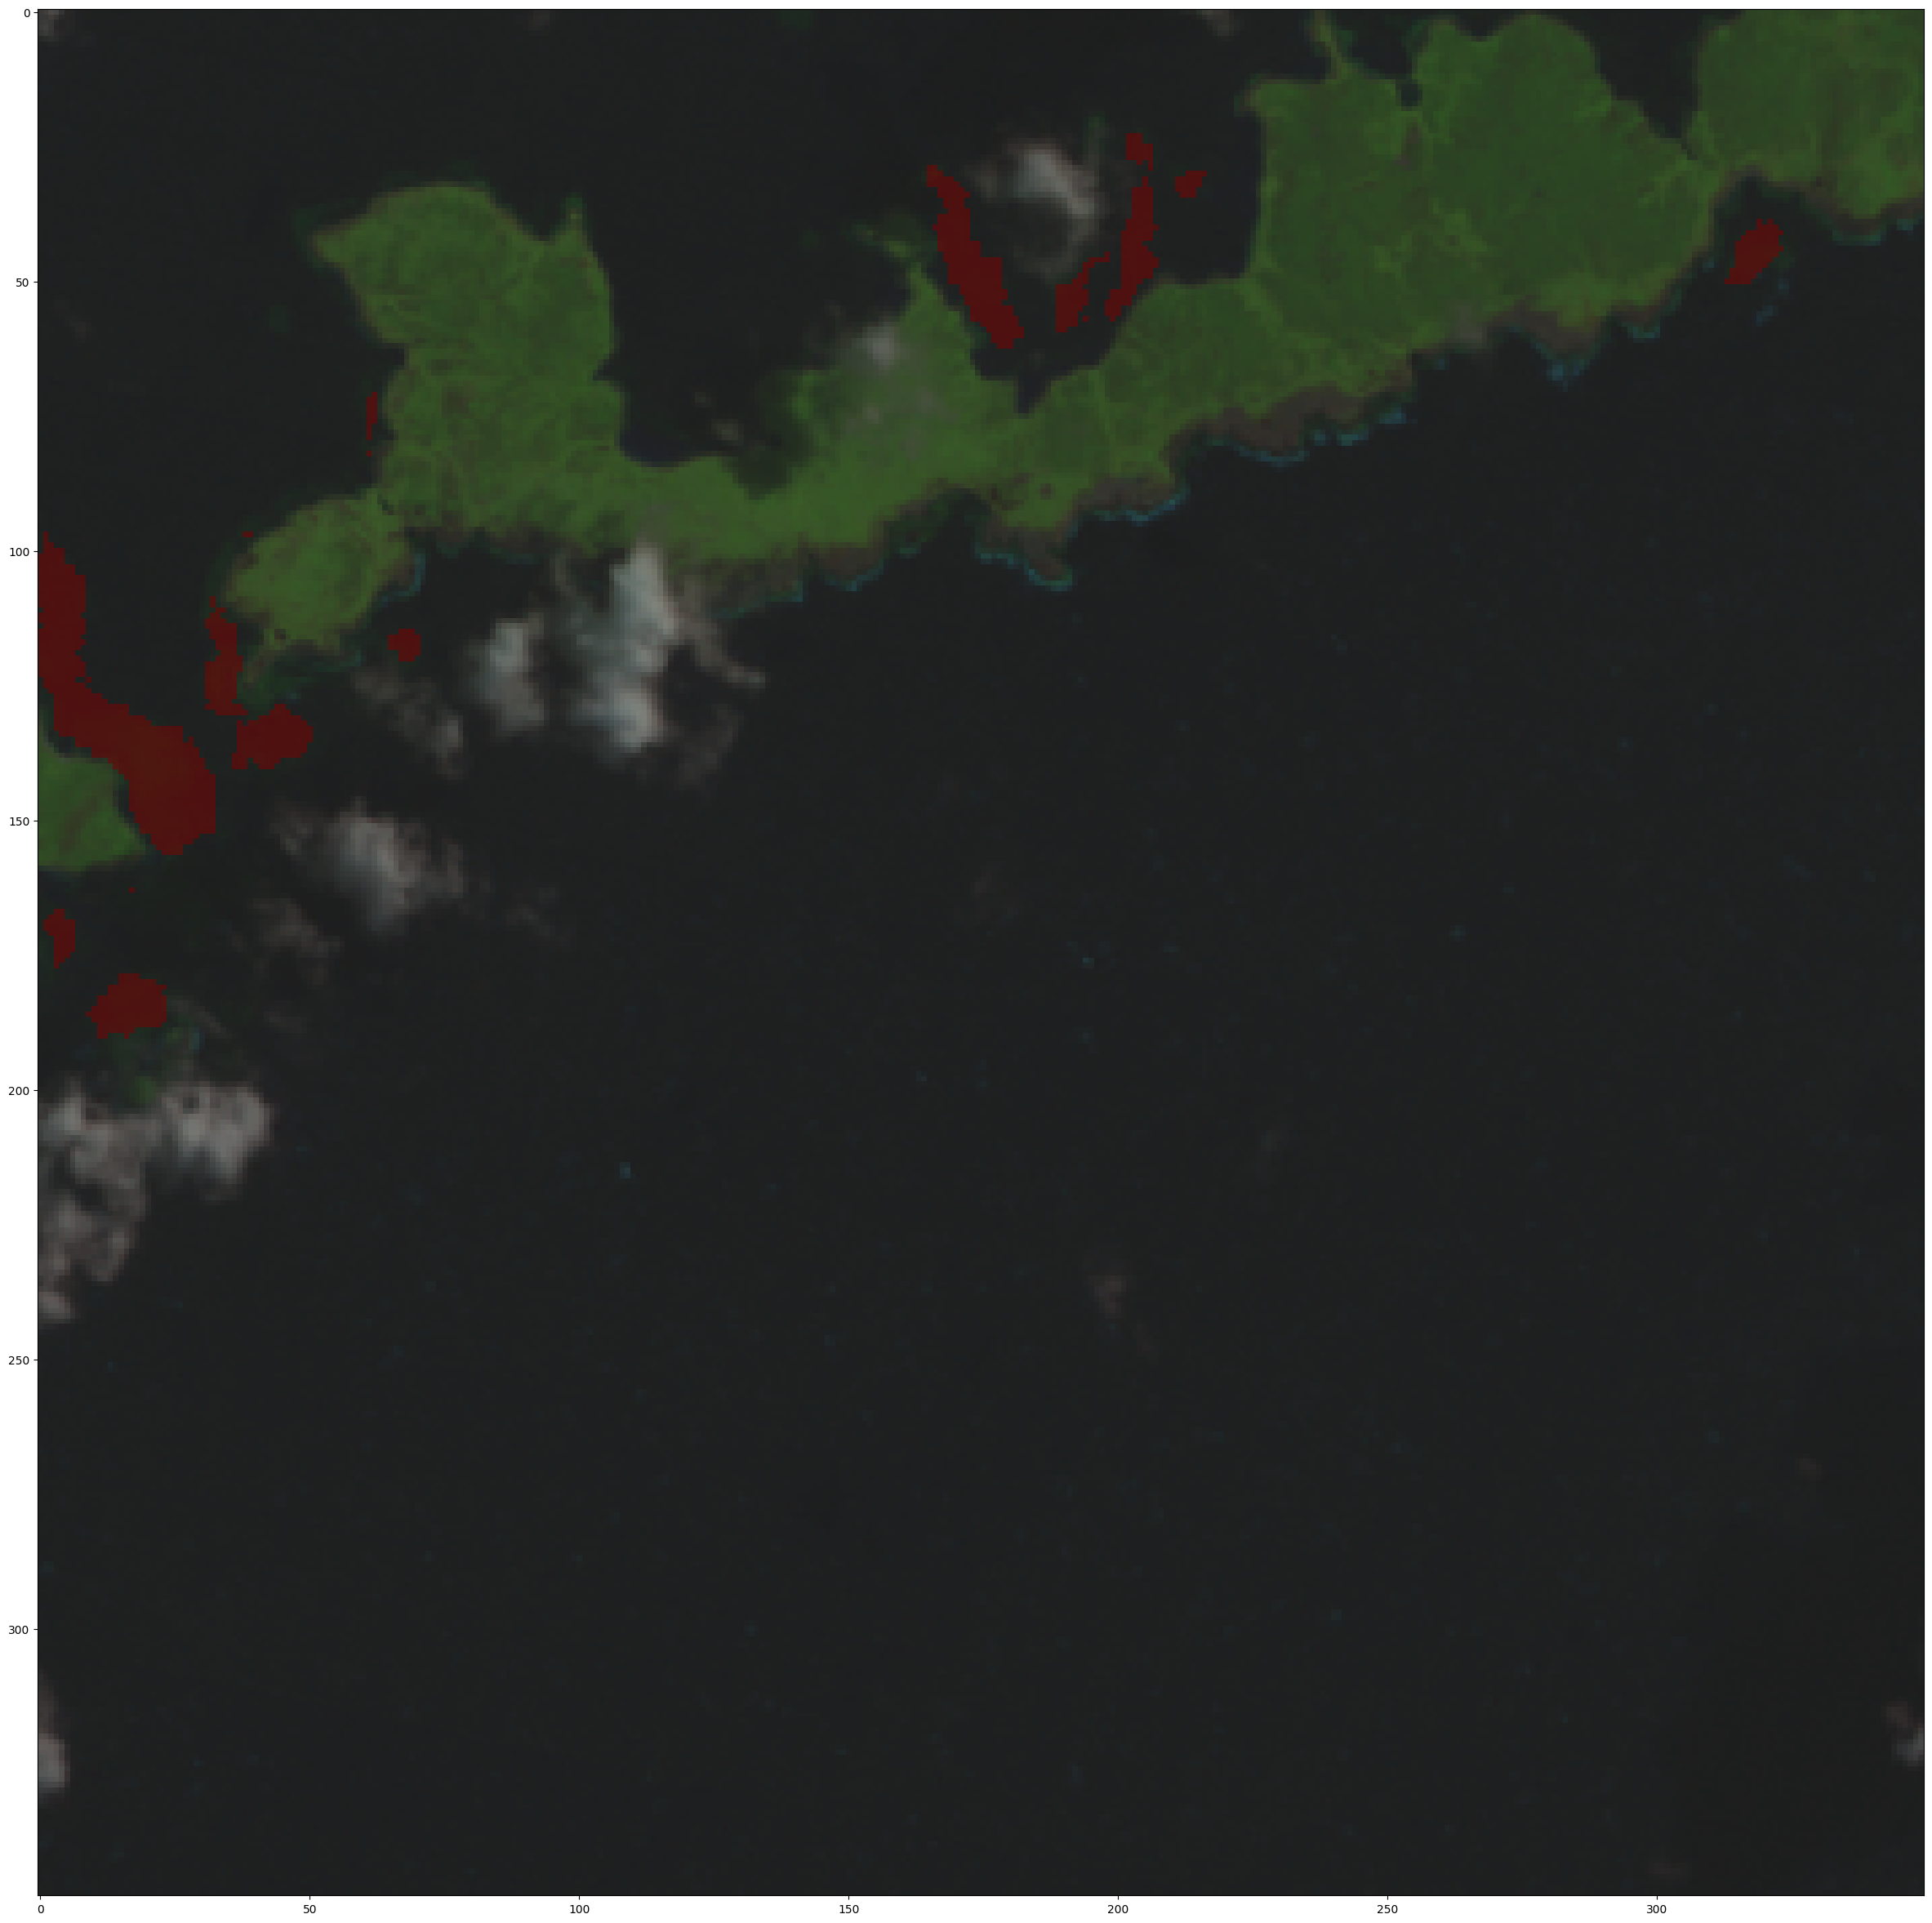

In [184]:
fig, axes = plt.subplots(1,1 , figsize=(30,30))

c = 2

show(normalized_images_array[2, 0:3, : , :], ax=axes)
axes.imshow(y_train_small[c][0], cmap='jet', alpha=0.5*(y_train_small[c][0]>0))